# Bike-Sharing Demand

## CRISP-DM Methodology

### Business Understanding

- Could include the idea of the casual vs registered users. "Thought about dropping these features but then thought these numbers could be affected by weather etc. "

### Data Terminology

**datetime** - hourly date + timestamp  <br>
**season** 
-  1 = spring
-  2 = summer 
-  3 = fall
-  4 = winter<br>

**holiday** - whether the day is considered a holiday<br>
**workingday** - whether the day is neither a weekend nor holiday<br>
**weather** 
- 1: Clear, Few clouds, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist            
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius<br>
**atemp** - "feels like" temperature in Celsius<br>
**humidity** - relative humidity<br>
**windspeed** - wind speed<br>
**casual** - number of non-registered user rentals initiated<br>
**registered** - number of registered user rentals initiated<br>
**count** - number of total rentals<br>

In [1]:
# Import pandas, numpy and matplotlib libraries
import pandas as pd
import numpy as np
import calendar
import pylab
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from sklearn.utils import shuffle
from sklearn import metrics
import statsmodels.formula.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold,train_test_split
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

/home/Emmet62/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Understanding

We want to get a good understanding of our dataset and the information contained within it. We can explore the structure and format of our dataset. Allows us to examine features (raw/derived, continuous/categorical), dataset shape, explore null values and cardinality, etc.

We can examine our Analytics Base Table (ABT) with a few different approaches

### Read in Dataset

In [2]:
# Convert csv file into dataframes
df1 = pd.read_csv('FullDataset.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
# Print the first 5 rows
df1.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


One point to note early on is the datetime column. This provides the year, month, day and time. We can extract this information from the datetime column and use it to generate new columns 

### Check Rows and Columns

We want to get the basic shape of our ABT in terms of number of rows and number of columns

In [3]:
# Check how many rows and columns this dataframe has
df1.shape

(10886, 12)

We now want to check if we have any constant columns in our ABT. Constant columns provide us with no information and should be removed

In [4]:
# checks dataframe and prints out the name of any constant columns
# checks if constant by seeing if any column's number of unique values equals 1
count=0
for column in df1:
    if len(df1[column].unique()) == 1:
        count += 1
        print(column + " is constant")
if count==0:
    print("There are no constant columns")

There are no constant columns


We also want to check if there are any duplicated rows that need to be deleted

In [5]:
#checked for duplicate rows, of which there are none
print(df1.set_index('datetime').index.get_duplicates())

[]


_Check for duplicated columns_

### Check Data Types

Need to know which of our features are continuous/categorical

In [6]:
#Show the data type of each column
df1.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Check Number of Unique Values

In [7]:
#Check unique values for each feature
print("Feature, UniqueValues") 
for column in df1:
    print(column + "," + str(len(df1[column].unique())))

Feature, UniqueValues
datetime,10886
season,4
holiday,2
workingday,2
weather,4
temp,49
atemp,60
humidity,89
windspeed,28
casual,309
registered,731
count,822


We can use the above to help us decide which features to convert to categorical. We can see that season, holiday, workingday and weather are all listed as continuous. However, they only have 2-4 unique values. Exploring the dataset we can see that these numbers are used to represent categories and should not be listed as numerics. We will convert them below

### Convert to Categorical

In [8]:
# Select columns containing categorical data
categorical_columns = df1[['season','holiday','workingday','weather']]
# Convert data type to category for these columns
for column in categorical_columns:
    df1[column] = df1[column].astype('category')
# Select columns containing continuous data
continuous_columns = df1.select_dtypes(exclude=['category']).columns
#Remove datetime (our index) from the continuous columns as it is neither a continuous or categorical feature
continuous_columns = continuous_columns.drop('datetime')
df1.dtypes

datetime        object
season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
dtype: object

### Missing Values

Before we do anything else we want to check if our datset contains any missing values. Missing values can cause problems so we want to check for them now so potential solutions can be devised if needed

In [9]:
# Check whether there are null values in the data where values would be expected
df1.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

Our dataset has no missing values which is good

### Irregular Cardinality

Categorical features can have irregular cardinality if the same value is entered several times with a different spelling for example. In the following cell, we check whether there are any values in the categorical features which are duplicated because 
of spelling mistakes or different input standards

In [10]:
# Check for irregular cardinality in categorical features. There could be same values spelled differently
print("Unique values for:\n- Season:", pd.unique(df1.season.ravel()))
print("\n- Holiday:", (pd.unique(df1.holiday.ravel())))
print("\n- Workingday:", (pd.unique(df1.workingday.ravel())))
print("\n- Weather:", (pd.unique(df1.weather.ravel())))

Unique values for:
- Season: [1 2 3 4]

- Holiday: [0 1]

- Workingday: [0 1]

- Weather: [1 2 3 4]


All of the above are fine

### Tables for Descriptive Features

Tables provide a nice description of the features in the ABT, using standard statistical measures of central tendency and variation

Tables show different stats for continuous features (e.g., numeric) versus categorical features (e.g., discrete)

In [11]:
# Print table
df1.select_dtypes(['category']).describe().T

,count,unique,top,freq
season,10886,4,4,2734
holiday,10886,2,0,10575
workingday,10886,2,1,7412
weather,10886,4,1,7192


The above table doesn't provide us with much insight. The only thing to infer is that ~70% of the weather falls into category 1 (Clear, Few clouds, Partly cloudy). This weather is conducive to cycling 

In [12]:
# Print table
df1[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


The table for the continuous features are more interesting. The mean and standard deviation of each feature give a sense of the central tendency and variation of the values within the dataset. The minimum and maximum values give the range that is possible for each feature. The percentiles also measure the variation of the values for a feature 

Our target feature for this project is count. We can see from the above that count has quite a large variation. The max figure (977) is noticeably larger than the 3rd quartile figure (284) which suggests we may have some outliers

## Visual Representations of Data

The best way to explore our ABT is using visual representations. We can plot a  histogram or boxplot for each continuous
feature and a bar plot for each categorical feature

### Continuous Histograms

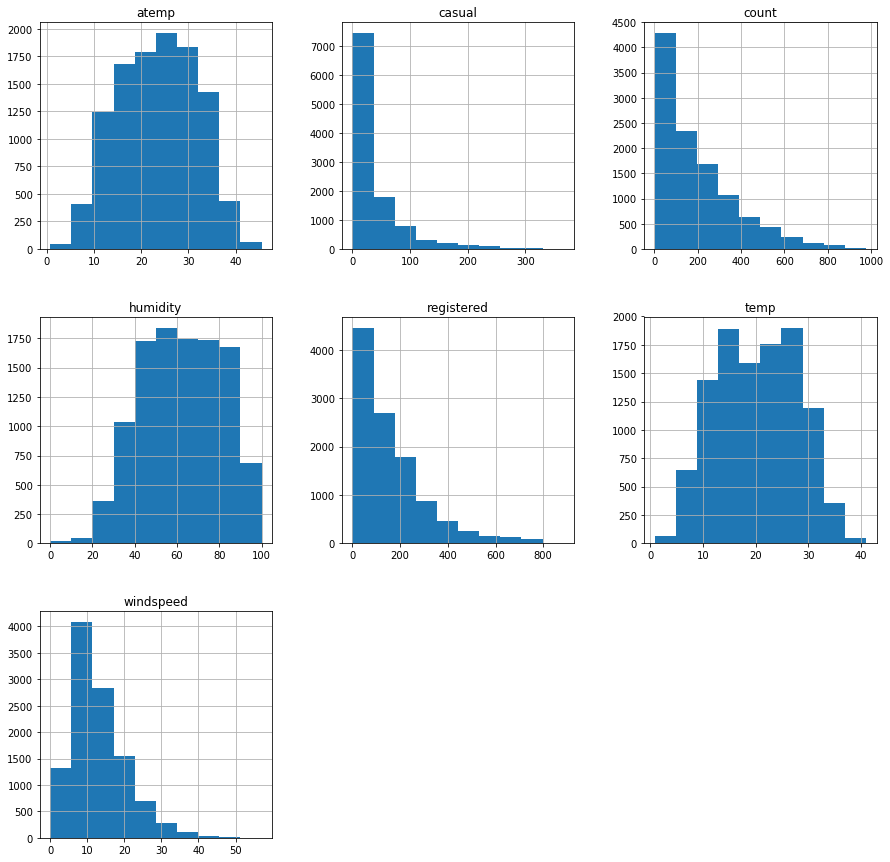

In [13]:
# Plot a histogram of the continuous features and save in a PDF file
df1[continuous_columns].hist(figsize=(15,15))
plt.savefig('continuous_histograms_17203166.pdf')

Some interesting points to note:
-  temp and atemp look very similar. May not be pertinent to keep both if they record almost the same data
-  casual, registered and count are all skewed right. casual and registered combined give count so we can focus on that feature. ~4,250 of our rows fall into the bin with 0-100 bikes.

### Continuous Box Plots

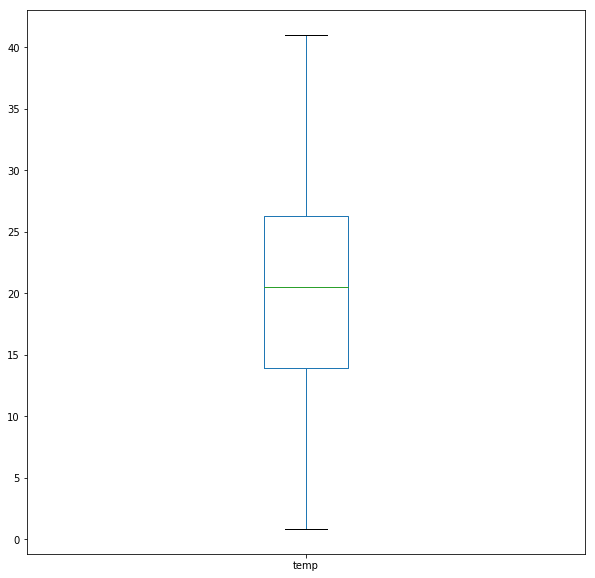

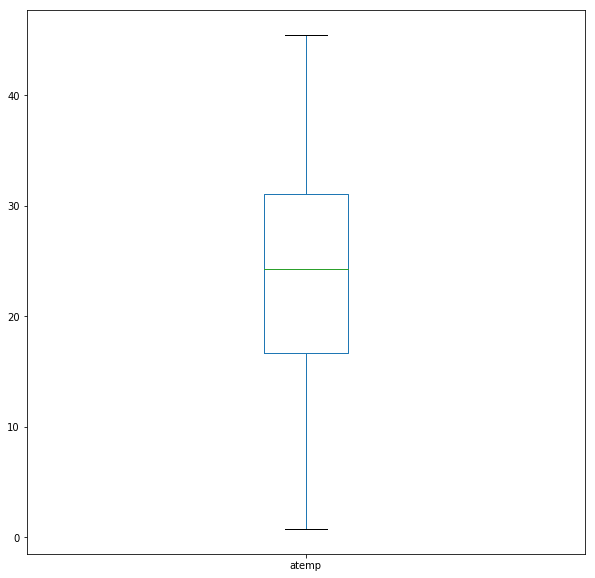

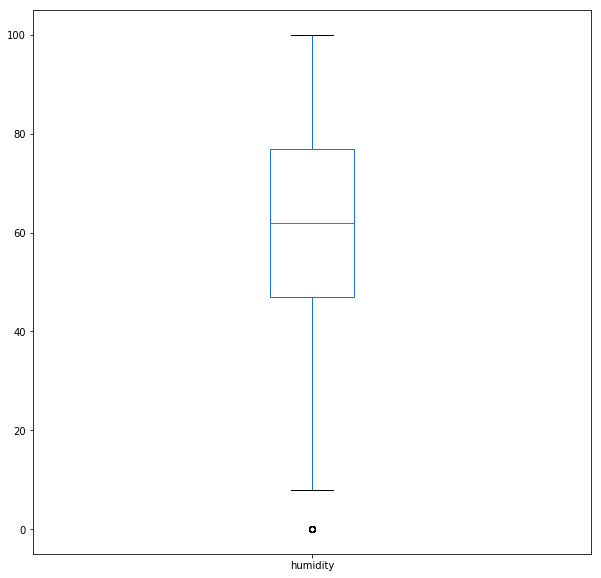

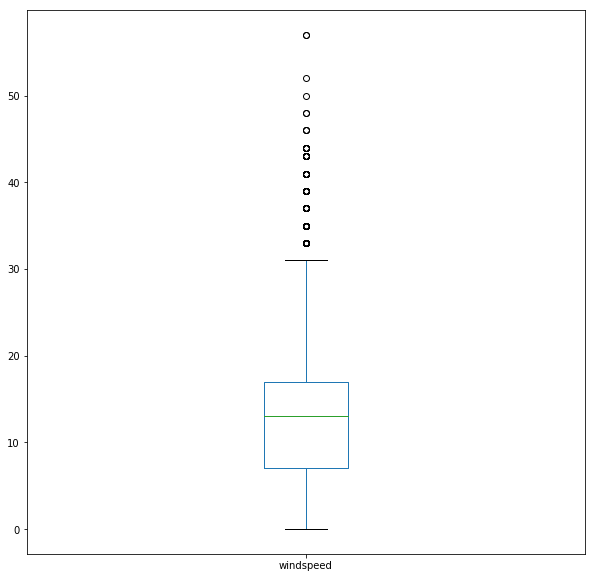

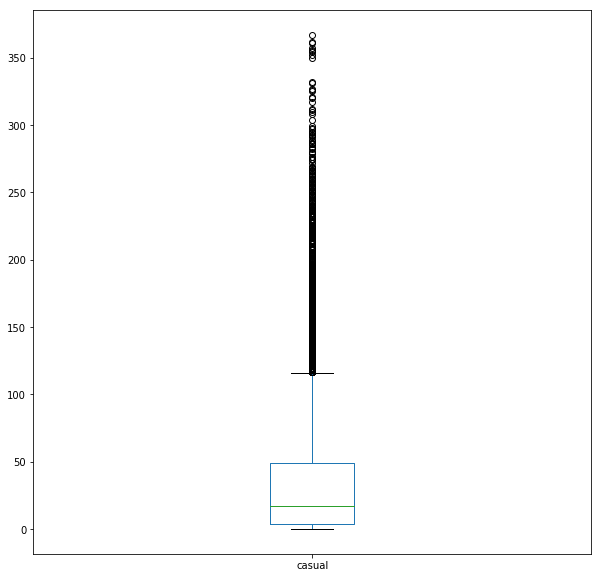

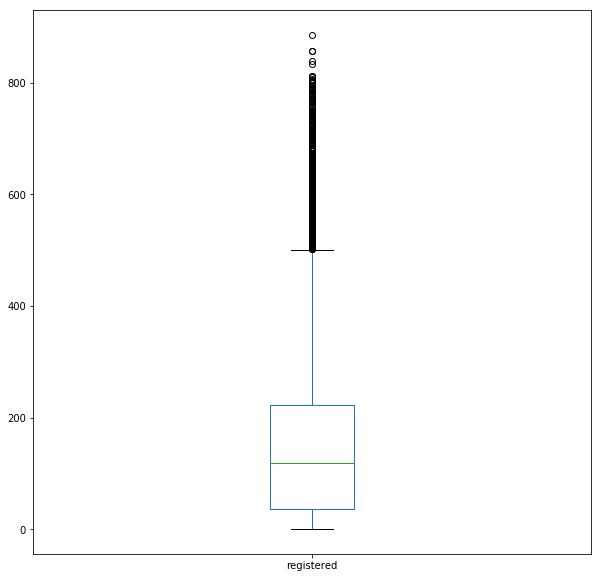

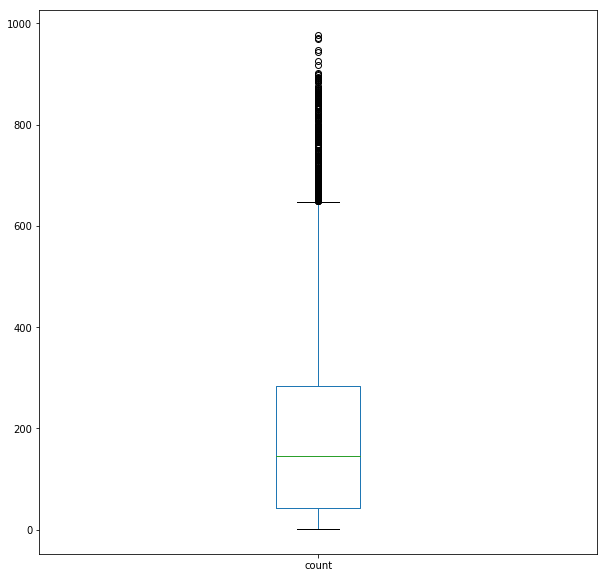

In [14]:
# Plot box plots for all the continuous features and save in a PDF file
pp = PdfPages('continuous_box_plots.pdf')

for col in continuous_columns:
    f = df1[col].plot(kind='box', figsize=(10,10))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

Again, temp and atemp are very similar in the above which means we probably don't need to include both. Looking at count we can see that there are a lot of outliers as we expected. We will explore this more later

### Continuous Correlation

We want to see what features are correlated with count so we can choose which to include in our models later

In [15]:
# Look at correlations for all the continuous features.
df1[continuous_columns].corr()

,temp,atemp,humidity,windspeed,casual,registered,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948
count,0.394454,0.389784,-0.317371,0.101369,0.690414,0.970948,1.000000


The above is a bit difficult to read. It would be better to explore these relationships visually. We can do this by plotting a correlation matrix

## Correlation Matrix

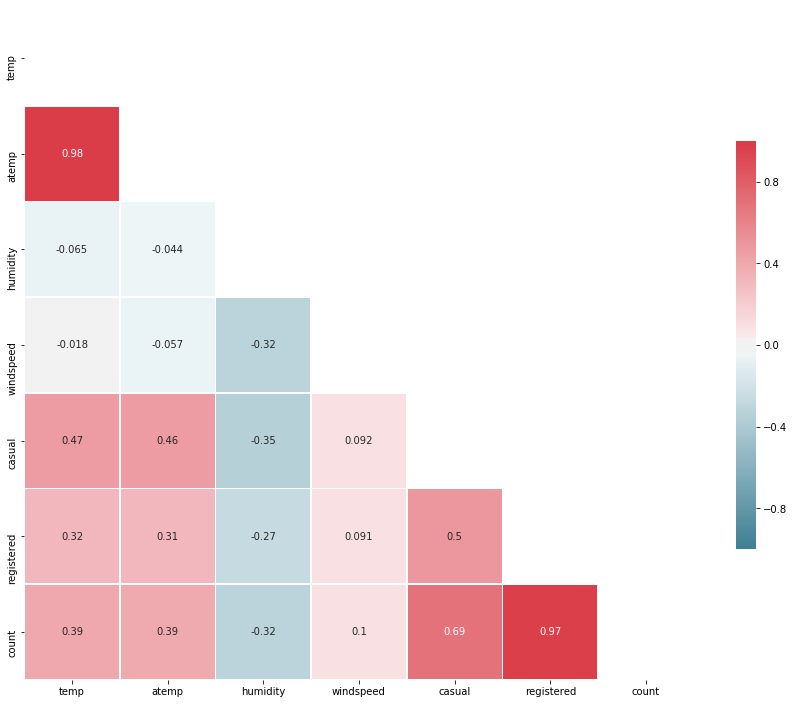

In [16]:
#Heatmap showing the correlation between different continuous feature pairs
corr = df1[continuous_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The strongest relationship is between temp and atemp (0.98). This is not surprising as we expect temperature and 'feels like' temperature to be strongly positively correlated.

We will ignore casual and registered as we want to focus on count. Count is simply the summation of casual and registered. It is clear that count doesn't have a particularly strong relationship with anything. temp/atemp is the highest at 0.39. This will be important when we start choosing what features to train our model with. 

## Scatterplots for Continuous Features

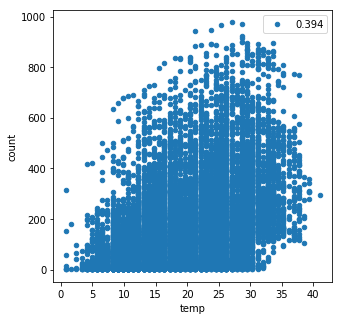

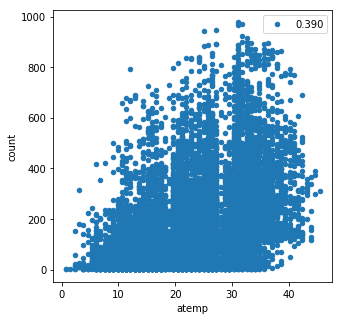

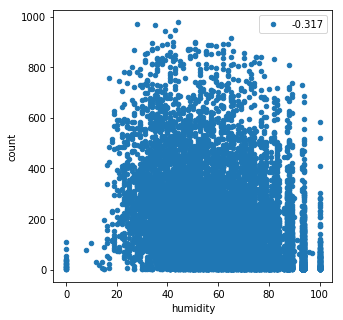

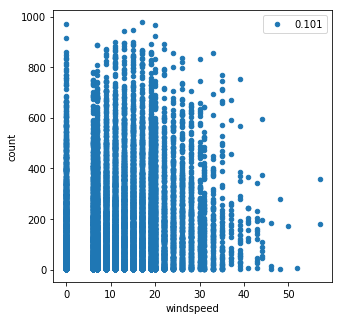

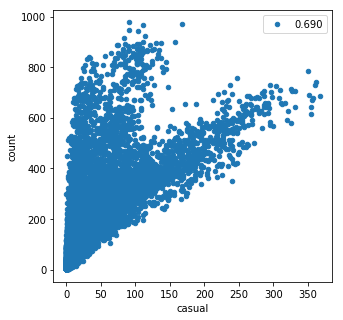

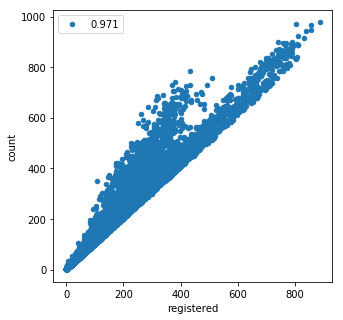

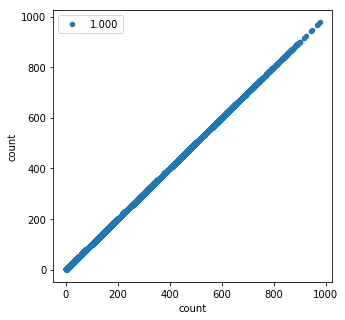

In [17]:
# Scatterplots for correlation between each continuous feature and churn
for col in continuous_columns:
    df1.plot(kind='scatter', x=col, y='count', label="%.3f" % df1[[col, 'count']].corr().as_matrix()[0,1], figsize=(5, 5))

It is difficult to infer much from the above scatterplots

### Categorical Bar Charts

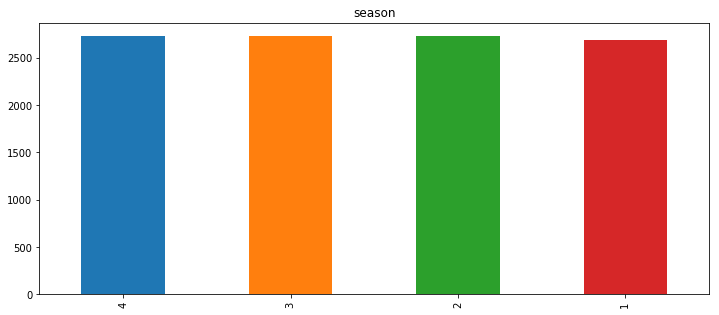

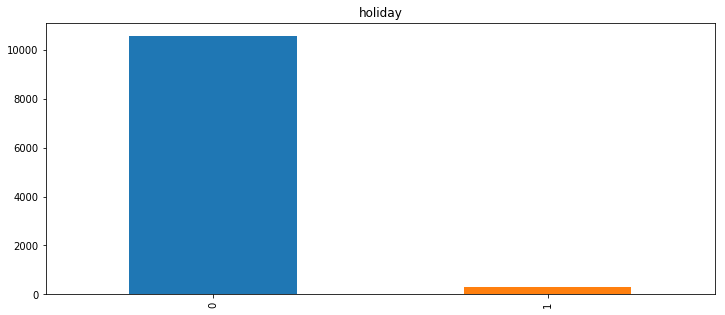

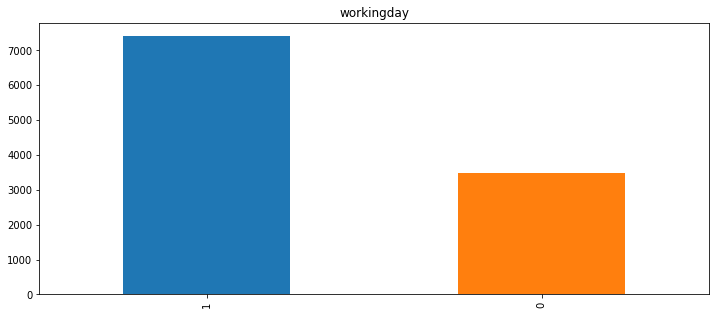

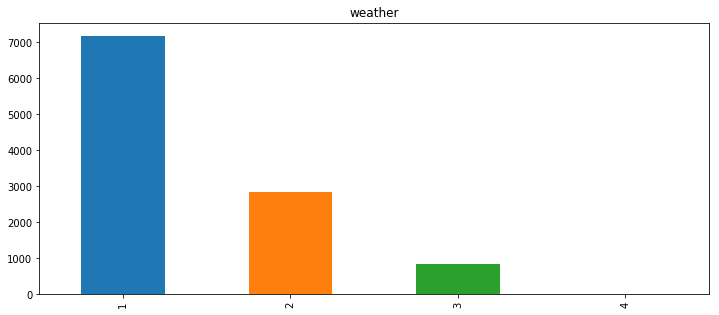

In [18]:
# Plot bar charts for all categorical features and save them in a single PDF file
pp = PdfPages('categorical_bar_charts.pdf')

for column in categorical_columns:
    f = df1[column].value_counts().plot(kind='bar', title=column, figsize=(12,5))
    pp.savefig(f.get_figure())
    plt.show()

pp.close()

Again, the bar charts by themselves don't tell us anything. Everything we see is to be expected. Only point worth noting is in weather; ~7000 rows are in category 1 (Clear, Few clouds, Partly cloudy) while very few are in 4 (Heavy Rain + Ice Pellets + Thunderstorm + Mist, Snow + Fog). Worth noting for later

### Boxplots for Categorical Features Vs. Count

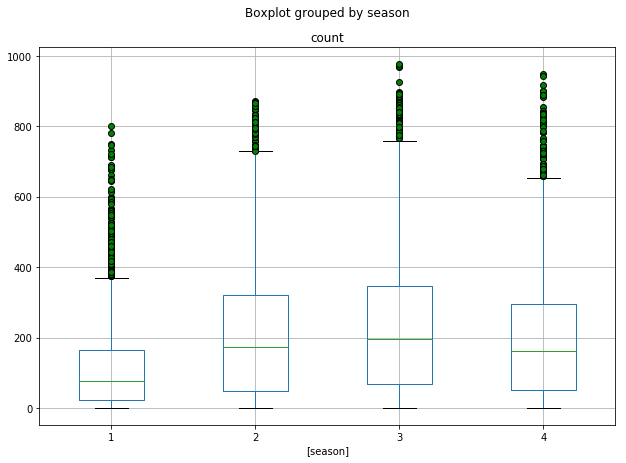

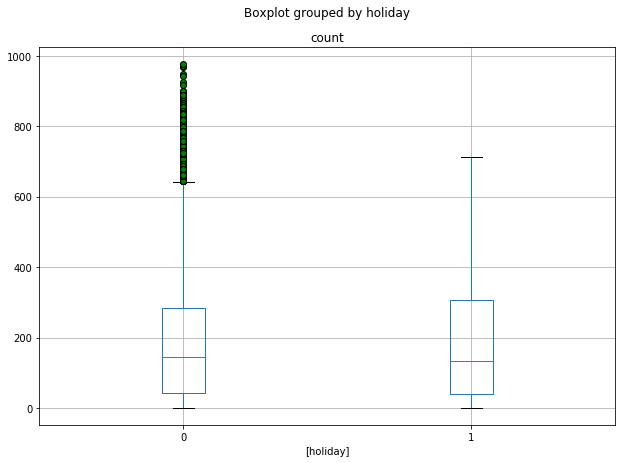

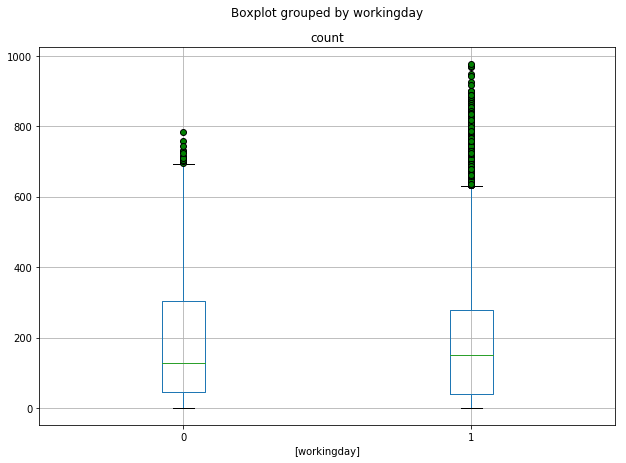

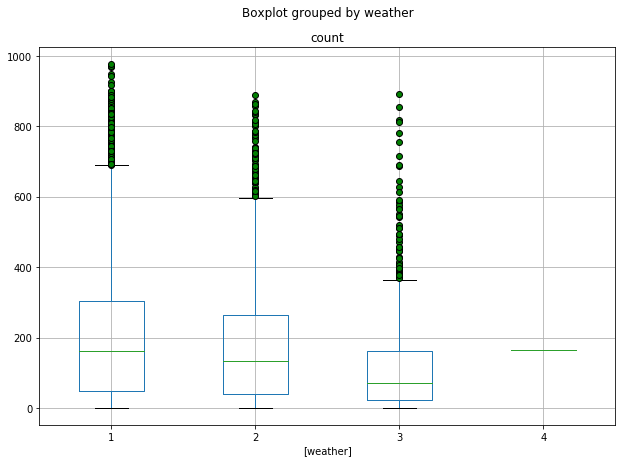

In [19]:
#Boxplots showing interaction between each categorical feature and the target feature
pp = PdfPages('categorical_vs_count_boxplots.pdf') #Save figures to a PDF
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
for col in categorical_columns:
    bp = df1.boxplot(column=['count'], by=[col], flierprops=flierprops, figsize=(10,7))
    pp.savefig(f.get_figure())    
pp.close()

Points to note:
-  Spring (1) has got a relatively lower count versus the other seasons. The dip in median value in boxplot gives evidence for it. Autumn (3) has the highest median value. 
-  The box plot for holiday and non-holiday are quite similar. Non-holiday has a lot more outliers
-  The box plot for workingday and non-workingday are also quite similar. This time workingday has a lot more outliers (this makes sense that it is the opposite of holidays, as most non-holidays will be workingdays)
-  The weather/count boxplot is interesting. As is to be expected, the highest median values are for 1 and 2. These are the categories for decent cycling weather. Category 3 denotes 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds' and so the median value for this is understandably lower

### Explore Weather Further 

In [20]:
# Return the number of customers for each unique value for feature Age
df1.groupby('weather')['weather'].apply(lambda x: x.count())

weather
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

From the data visualisations we saw that very few rows had a weather category of 4. From the above we can see that only a single row fell into this category 

### Investigate Outliers in Count

Outliers skew the data. Earlier we saw that count contains a lot of outleirs i.e. data points beyond the outer quartile limit. Learning algorithms work best on data that exhibits a Gaussian distribution. To try and reduce this skewness we will explore clamping some of these outliers 

### Clamping Outliers

In [21]:
# In the box plot above, we can see that there are a number of outliers in the 'count' feature. This could be
# an error or it could be due to the fact that the outlier is just actually busier

# Find out the 5 rows with the highest number for count
df1.sort_values(by='count', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
9345,2012-09-12 18:00:00,3,0,1,1,27.06,31.060,44,16.9979,91,886,977
9320,2012-09-11 17:00:00,3,0,1,1,28.70,31.820,28,0.0000,168,802,970
9297,2012-09-10 18:00:00,3,0,1,1,25.42,31.060,35,19.9995,111,857,968
9752,2012-10-10 17:00:00,4,0,1,1,23.78,27.275,43,15.0013,91,857,948
9896,2012-10-16 17:00:00,4,0,1,1,21.32,25.000,39,12.9980,104,839,943


_Sorting by count we can see that the outliers are explainable. We can look at clamping them or we can say that we decided to keep them in as they made sense. The highest counts come during the busiest times in terms of hour of the day and month of the year i.e. commuting times in Summer/Autumn._

Clamping = replace all values above/below an upper/lower threshold, thus removing the outliers

Upper threshold = 3rd quartile + 1.5IQR

IQR = 3rdQ - 1stQ = 284 - 42 = 242

284 + 1.5(242) = 647


### Visual Dsitribution of Data (Log Transformation)

_Should we use log transformation on count to make it more normally distributed?_

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.3647396459244168, 4.591363690454027, 0.9611793780126955))

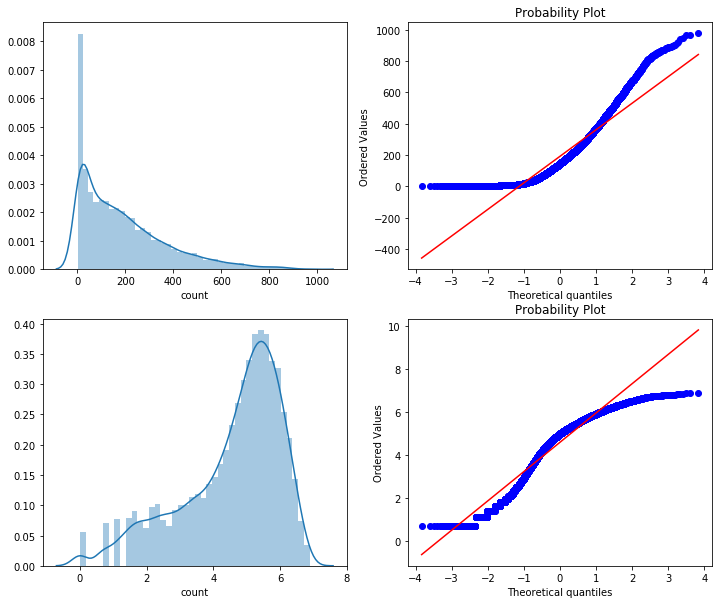

In [22]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(df1["count"],ax=axes[0][0])
stats.probplot(df1["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(df1["count"]),ax=axes[1][0])
stats.probplot(np.log1p(df1["count"]), dist='norm', fit=True, plot=axes[1][1])

We were looking into ways to make our data normally distributed so that it would be more conducive to our prediction models. One avenue we looked into was using a log transformation on count to try and change its distribution. Although from the above it seemed promising, further research online showed that this isn't always a good approach. After discussing amongst ourselves, we decided to not perform the log transformation and leave count as was

### Data Quality Plan

Based on the above exploration of the data, we have devised some changes to make to our ABT. We believe these will allow us to train a more accurate predictive model

| Feature                 | Data Quality Issue    | Handling Strategy            |
|-------------------------|-----------------------|------------------------------|
| Datetime                | Unusable info         | Convert to date              |
| Datetime                | Unusable info         | Convert to hour              |
| Datetime                | Unusable info         | Convert to weekday           |
| Datetime                | Unusable info         | Convert to month             |
| Datetime                | Useful info extracted | Drop column                  |
| count                   | Outliers              | Do nothing                   |
| weather                 | Only one value in W4  | Drop column                  |
| season                  | Separate columns      | Normalise data               |
| weather                 | Separate columns      | Normalise data               |
| casual                  | Leakage variable      | Drop column                  |
| registered              | Leakage variable      | Drop column                  |
| atemp                   | Similar to temp       | Drop column                  |

# Data Preparation

### Datetime

This dataset included a datetime column. We can extract information from this and use it to populate new columns. We can extract the hour, weekday and month for each row

This is helpful as we can then check if these data fields correlate with count and possibly incorporate them into our model

In [23]:
# The below was adapted from https://stackoverflow.com/questions/41783003/how-do-i-convert-timestamp-to-datetime-date-in-pandas-dataframe
# We create four new columns and populate each using info extracted from datetime column
df1["date"] = df1.datetime.apply(lambda x : x.split()[0])
df1["hour"] = df1.datetime.apply(lambda x : x.split()[1].split(":")[0])
df1["weekday"] = df1.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df1["month"] = df1.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

In [24]:
# Convert these new columns to category
categoryVariableList = ["hour","weekday","month"]
for var in categoryVariableList:
    df1[var] = df1[var].astype("category")

In [25]:
# Print the first row to check that this has worked as intended
df1.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,00,Saturday,January


In [26]:
# We no longer need datetime column so we can drop it
df1 = df1.drop(["datetime"],axis=1)

We can use these new columns to plot some nice charts to visualise and explore the data

[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

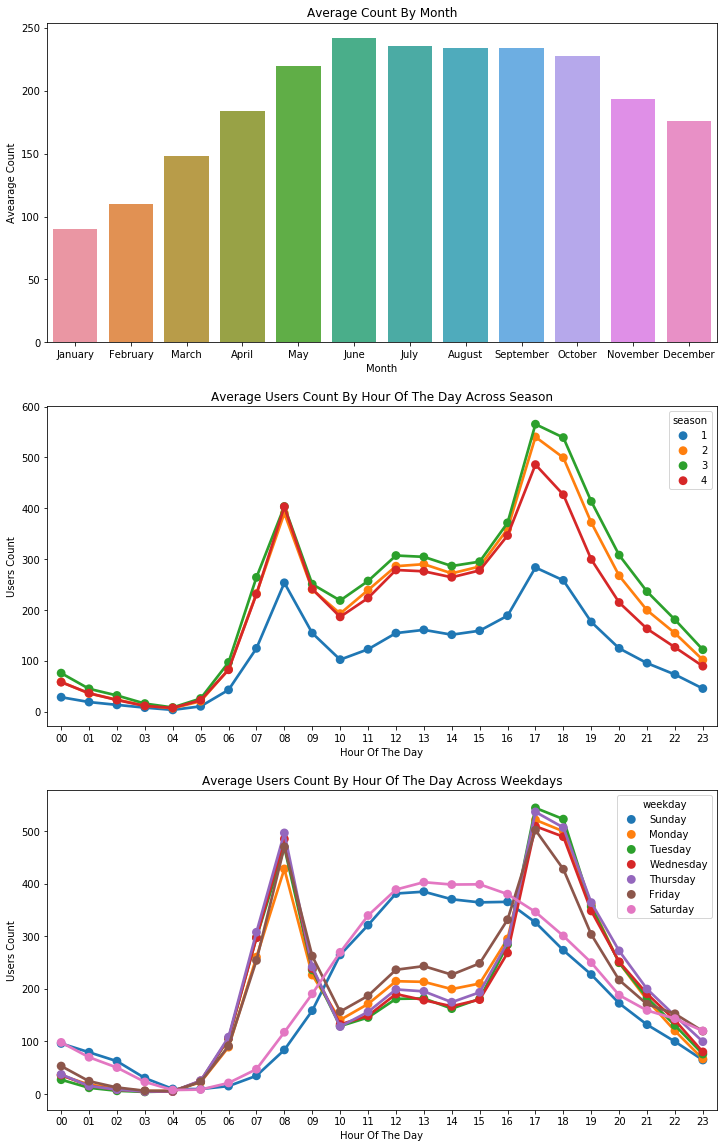

In [27]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(df1.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(df1.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(df1.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')



### Drop casual, registered and atemp

Both temp and atemp are strongly correlated which may cause multicorrelation, so we will drop atemp to avoid this.
Count is made up of registered and casual, so we will drop them to avoid leakage <br>
Note:Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed)

In [28]:
# We do not need these columns so we can drop them
df1 = df1.drop(["casual"],axis=1)
df1 = df1.drop(["registered"],axis=1)
df1 = df1.drop(["atemp"],axis=1)
df1.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,count,date,hour,weekday,month
0,1,0,0,1,9.84,81,0.0,16,2011-01-01,00,Saturday,January
1,1,0,0,1,9.02,80,0.0,40,2011-01-01,01,Saturday,January
2,1,0,0,1,9.02,80,0.0,32,2011-01-01,02,Saturday,January
3,1,0,0,1,9.84,75,0.0,13,2011-01-01,03,Saturday,January
4,1,0,0,1,9.84,75,0.0,1,2011-01-01,04,Saturday,January


### Normalise Weather

In [29]:
df_W1 = (df1.weather==1) * 1.0
df_W2 = (df1.weather==2) * 1.0
df_W3 = (df1.weather==3) * 1.0
df_W4 = (df1.weather==4) * 1.0
df_W = pd.DataFrame({'W1': df_W1, 'W2': df_W2,'W3': df_W3,'W4': df_W4,})
df_W[:10]

,W1,W2,W3,W4
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0
7,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0


In [30]:
#Drop weather category 4 which only has 1 true value
df_W = df_W.drop('W4',1)

### Normalise Season

In [31]:
df_S1 = (df1.season==1) * 1.0
df_S2 = (df1.season==2) * 1.0
df_S3 = (df1.season==3) * 1.0
df_S4 = (df1.season==4) * 1.0
df_S = pd.DataFrame({'spring': df_S1, 'summer': df_S2,'autumn': df_S3,'winter': df_S4,})
df_S[:10]

,autumn,spring,summer,winter
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0
8,0.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0


### Concatenate Dataframes and Drop Season/Weather

In [32]:
df1 = pd.concat([df1, df_W, df_S], axis = 1)
df1 = df1.drop('season', 1)
df1 = df1.drop('weather', 1)

### Change Weekday to Numeric Values

In [33]:
df1['weekday'] = df1['weekday'].replace('Monday',1)
df1['weekday'] = df1['weekday'].replace('Tuesday',2)
df1['weekday'] = df1['weekday'].replace('Wednesday',3)
df1['weekday'] = df1['weekday'].replace('Thursday',4)
df1['weekday'] = df1['weekday'].replace('Friday',5)
df1['weekday'] = df1['weekday'].replace('Saturday',6)
df1['weekday'] = df1['weekday'].replace('Sunday',7)

### Change Month to Numeric Values

In [34]:
df1['month'] = df1['month'].replace('January', 1)
df1['month'] = df1['month'].replace('February', 2)
df1['month'] = df1['month'].replace('March', 3)
df1['month'] = df1['month'].replace('April', 4)
df1['month'] = df1['month'].replace('May', 5)
df1['month'] = df1['month'].replace('June', 6)
df1['month'] = df1['month'].replace('July', 7)
df1['month'] = df1['month'].replace('August', 8)
df1['month'] = df1['month'].replace('September', 9)
df1['month'] = df1['month'].replace('October', 10)
df1['month'] = df1['month'].replace('November', 11)
df1['month'] = df1['month'].replace('December', 12)

In [35]:
# Select columns containing categorical data
categorical_columns = df1[['workingday','holiday','W1','W2','W3','spring','summer','autumn','winter','weekday', 'month', 'hour']]
# Convert data type to category for these columns
for column in categorical_columns:
    df1[column] = df1[column].astype('category')
# Select columns containing continuous data
continuous_columns = df1.select_dtypes(exclude=['category']).columns
df1.dtypes

holiday       category
workingday    category
temp           float64
humidity         int64
windspeed      float64
count            int64
date            object
hour          category
weekday       category
month         category
W1            category
W2            category
W3            category
autumn        category
spring        category
summer        category
winter        category
dtype: object

## Investigate Promising Features

In [36]:
#fig, axes = plt.subplots(nrows=1,ncols=1)
#fig.set_size_inches(12, 10)
#sns.boxplot(data=df1,y="count",orient="v",ax=axes[0][0])
#sns.boxplot(data=df1,y="count",x="summer",orient="v",ax=axes[0][1])
#sns.boxplot(data=df1,y="count",x="hour",orient="v",ax=axes)
#sns.boxplot(data=df1,y="count",x="workingday",orient="v",ax=axes[1][1])

#axes[0][0].set(ylabel='Count',title="Count")
#axes[0][1].set(xlabel='Summer', ylabel='Count',title="Count Against Summer")
#axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Count Against Hour Of The Day")
#axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count Against Working Day")

Some points to note from the above:
-  Spring (1) has the lowest number of users. Summer (2) has the second lowest number of median users. This mat be due to be it being too hot to cycle in the summer. Average temperatures in July are 27°C
-  Autumn (3) has the highest relative median value. This may be because the weather in autumn is perfect for cycling. Not too hot or too cold
-  Comparing count against hour of the day produces some interesting results. We can clearly see that 7am and 6pm have the highest median values. This is understandable as these are prime commuting hours so bike activity is to be high

In [37]:
categorical_columns.head()

,workingday,holiday,W1,W2,W3,spring,summer,autumn,winter,weekday,month,hour
0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1,00
1,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1,01
2,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1,02
3,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1,03
4,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1,04


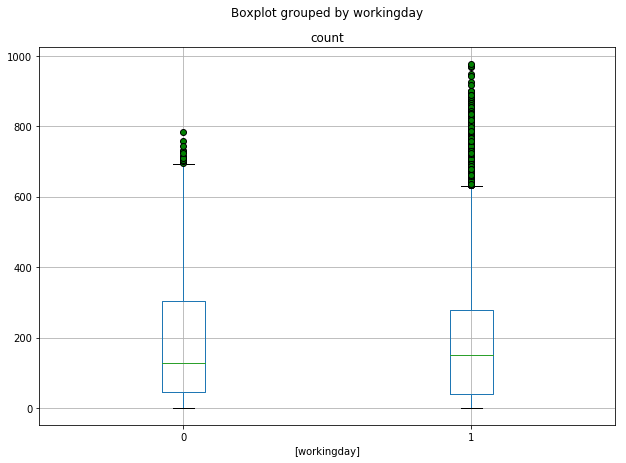

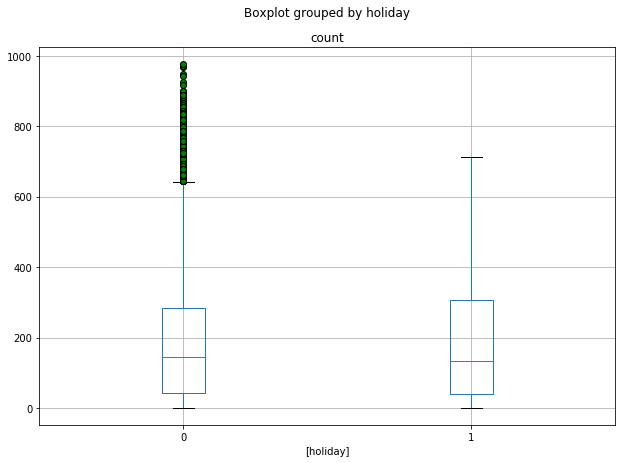

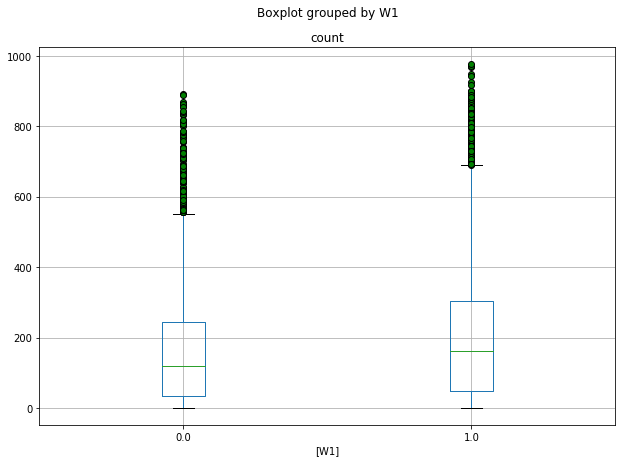

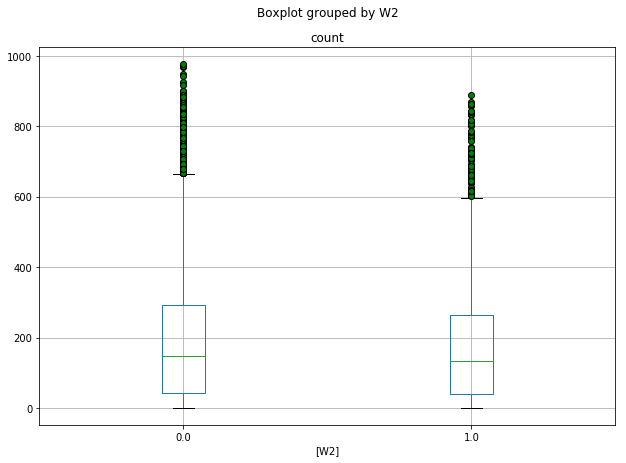

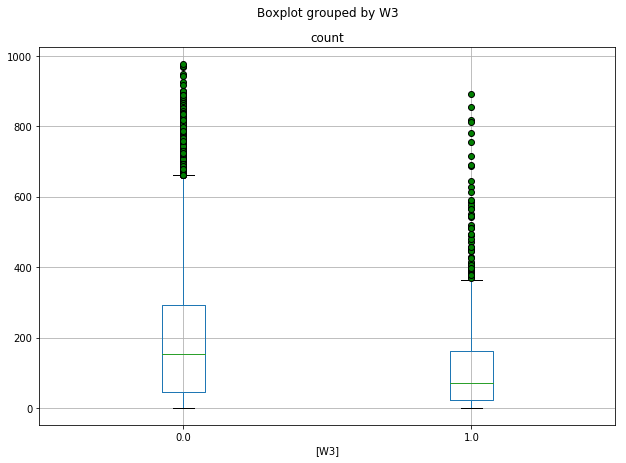

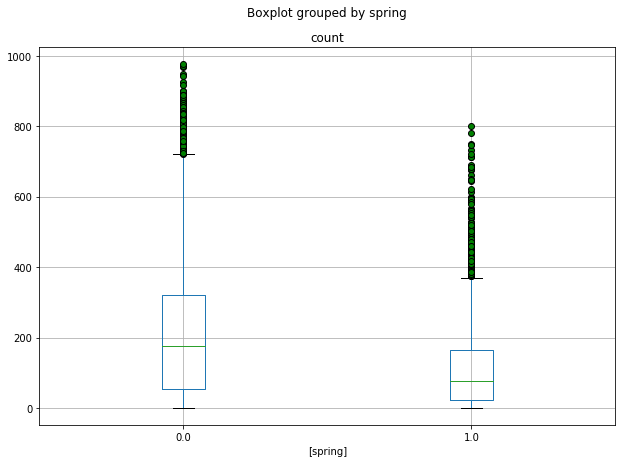

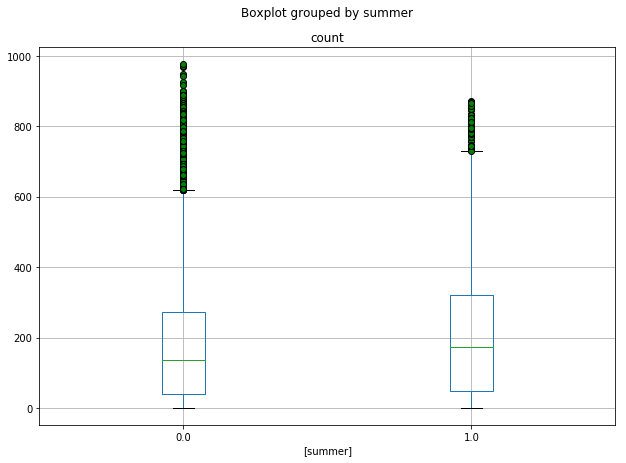

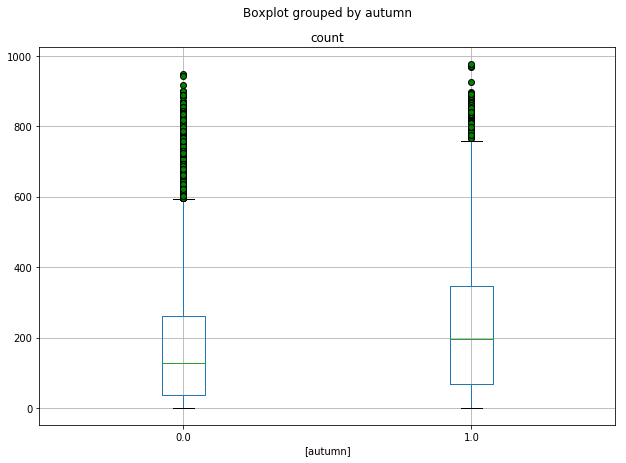

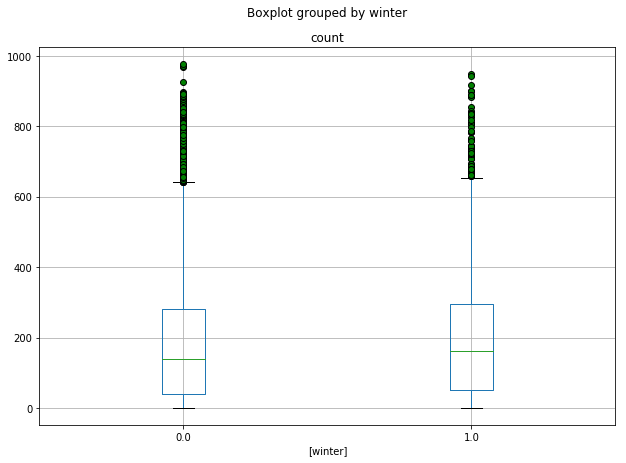

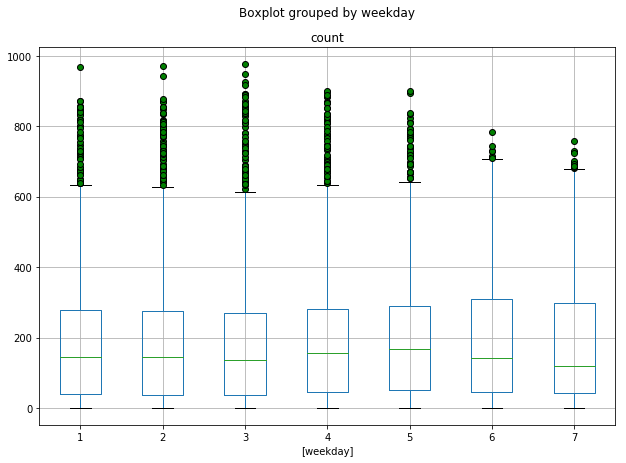

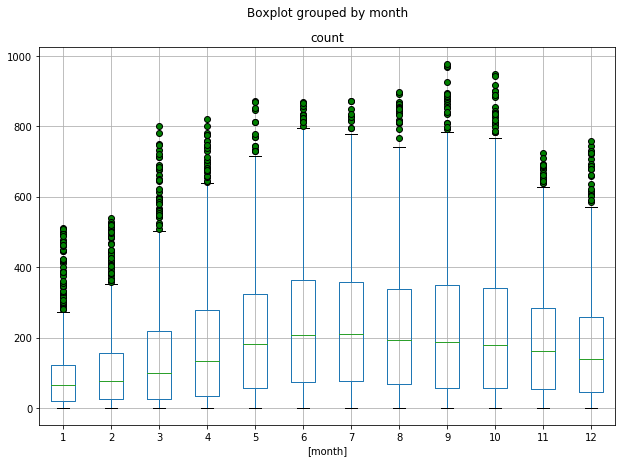

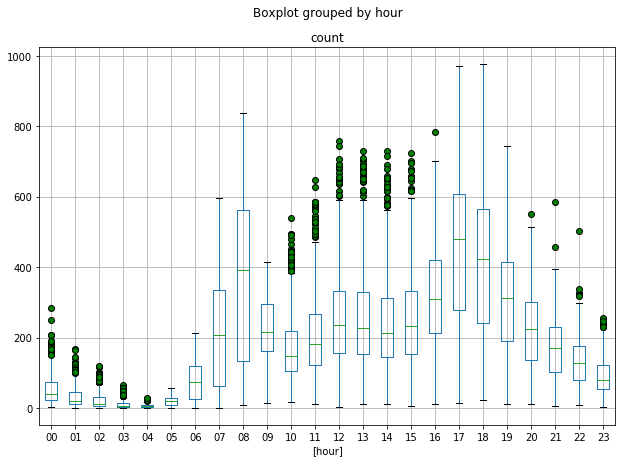

In [38]:
#Boxplots showing interaction between each continuous feature and the target feature
#pp = PdfPages('categorical_vs_count_boxplots.pdf') #Save figures to a PDF
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
for col in categorical_columns:
    bp = df1.boxplot(column=['count'], by=[col], flierprops=flierprops, figsize=(10,7))
#    pp.savefig(f.get_figure())    
#pp.close()

### Visualising count vs x, y, z

### Shuffle Dataset and Split

In [39]:
#cleaned = shuffle(df1)
#cleaned.to_csv('cleanedCSV.csv', index=False)
#Split the dataset into two datasets: 70% training and 30% test.
#y = cleaned[['count']]
#X_train, X_test, y_train, y_test = train_test_split(cleaned, y, test_size=0.3)
#Save the training dataframe to a csv
#X_train.to_csv('dftrain.csv',index=False)
#Save the test dataframe to a csv
#X_test.to_csv('dftest.csv',index=False)

In [40]:
# Convert the training csv file into dataframe
dftrain = pd.read_csv('dftrain.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

# Modeling

## Linear Regression

In [41]:
dftrain.tail()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter
7615,0,1,18.86,22.725,82,12.9980,26,130,156,2012-12-04,10,2,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7616,0,0,22.96,26.515,56,8.9981,31,117,148,2012-06-17,0,7,6,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7617,0,1,27.88,31.820,57,23.9994,42,323,365,2011-05-03,19,2,5,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7618,0,0,13.12,16.665,76,6.0032,16,106,122,2012-11-10,0,6,11,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7619,0,1,21.32,25.000,52,22.0028,8,124,132,2011-12-15,14,4,12,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [42]:
# Select columns containing categorical data
categorical_columns = dftrain[['workingday','holiday','W1','W2','W3','spring','summer','autumn','winter','weekday', 'month', 'hour']]
# Convert data type to category for these columns
for column in categorical_columns:
    dftrain[column] = dftrain[column].astype('category')
# Select columns containing continuous data
continuous_columns = dftrain.select_dtypes(exclude=['category']).columns
dftrain.dtypes

holiday       category
workingday    category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
hour          category
weekday       category
month         category
W1            category
W2            category
W3            category
autumn        category
spring        category
summer        category
winter        category
dtype: object

In [43]:
# Build a learning machine using the subset of features chosen in part 1
lm = sm.ols(formula="count ~ W1 + W3 + autumn + spring + hour + month", data=dftrain).fit()

# Print the model parameters (e.g coefficients)
print(lm.params)

Intercept         44.457186
W1[T.1.0]         16.779807
W3[T.1.0]        -77.382754
autumn[T.1.0]     32.590105
spring[T.1.0]   -103.381666
hour[T.1]        -16.833693
hour[T.2]        -29.983473
hour[T.3]        -41.940406
hour[T.4]        -46.170656
hour[T.5]        -33.446912
hour[T.6]         27.880395
hour[T.7]        160.983429
hour[T.8]        310.174831
hour[T.9]        168.477024
hour[T.10]       123.650316
hour[T.11]       157.637677
hour[T.12]       209.234682
hour[T.13]       196.304816
hour[T.14]       192.183981
hour[T.15]       197.993104
hour[T.16]       266.585205
hour[T.17]       434.159032
hour[T.18]       378.978148
hour[T.19]       272.973959
hour[T.20]       172.296688
hour[T.21]       122.776759
hour[T.22]        84.075170
hour[T.23]        39.569782
month[T.2]        23.040118
month[T.3]        57.314755
month[T.4]        -3.051096
month[T.5]        35.063455
month[T.6]        52.578060
month[T.7]         9.503049
month[T.8]         7.922629
month[T.9]        15

In [44]:
#Print the learning machine summary which is a bit more detailed than just the coefficients
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     345.5
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:59:35   Log-Likelihood:                -46753.
No. Observations:                7620   AIC:                         9.358e+04
Df Residuals:                    7583   BIC:                         9.384e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        44.4572      5.877      7.565

In [45]:
dftrain_predict = lm.predict(dftrain)
# Print the predicted target feature value for first 100 examples in the training dataset
dftrain_predict[:10]

0    290.204821
1    116.333242
2    207.150051
3    242.607596
4    487.969673
5    463.948067
6    306.984629
7     54.739865
8    151.654628
9    369.274407
dtype: float64

In [46]:
dftrain[['count']][:10]

,count
0,365
1,215
2,106
3,122
4,808
5,556
6,696
7,63
8,71
9,504


In [47]:
predict_df_train = pd.DataFrame({'ActualCount': dftrain['count'], 'PredictedCoun': lm.predict(dftrain)})
predict_df_train.head()

,ActualCount,PredictedCoun
0,365,290.204821
1,215,116.333242
2,106,207.150051
3,122,242.607596
4,808,487.969673


In [48]:
#Pair the actual and the predicted values
print("Difference Between Actual/Predicted:\n", (dftrain['count'] - lm.predict(dftrain)).head())


Difference Between Actual/Predicted:
 0     74.795179
1     98.666758
2   -101.150051
3   -120.607596
4    320.030327
dtype: float64


In [49]:
print("Difference Between Actual/Predicted (Squared):\n", ((dftrain['count'] - lm.predict(dftrain))**2).head())

Difference Between Actual/Predicted (Squared):
 0      5594.318733
1      9735.129144
2     10231.332873
3     14546.192259
4    102419.410187
dtype: float64


In [50]:
print("|Actual - Predicted|:\n", abs(dftrain['count']- lm.predict(dftrain)).head())

|Actual - Predicted|:
 0     74.795179
1     98.666758
2    101.150051
3    120.607596
4    320.030327
dtype: float64


In [51]:
# Print the Mean Squared Error of the model on the training set
mse = ((dftrain['count'] - lm.predict(dftrain))** 2).mean()
print("\nMean Squared Error:\n", mse)


Mean Squared Error:
 12498.332335440526


In [52]:
# Print the Mean Absolute Error of the model on the training set
mae = abs(dftrain['count'] - lm.predict(dftrain)).mean()
print("\nMean Absolute Error:\n", mae)


Mean Absolute Error:
 81.17381132084499


## Testing

In [53]:
# Convert the training csv file into dataframe
dftest = pd.read_csv('dftest.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

## Linear Regression

In [54]:
dftest.tail()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter
3261,0,1,22.96,26.515,56,12.9980,65,162,227,2012-06-05,11,2,6,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3262,0,0,22.14,25.760,68,12.9980,10,44,54,2011-09-18,23,7,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3263,0,0,18.86,22.725,88,19.9995,15,24,39,2011-01-01,23,6,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3264,0,1,13.94,15.910,87,15.0013,0,9,9,2012-01-11,23,3,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3265,0,1,14.76,16.665,57,19.0012,23,74,97,2011-03-15,13,2,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [55]:
# Select columns containing categorical data
categorical_columns = dftest[['workingday','holiday','W1','W2','W3','spring','summer','autumn','winter','weekday', 'month', 'hour']]
# Convert data type to category for these columns
for column in categorical_columns:
    dftest[column] = dftest[column].astype('category')
# Select columns containing continuous data
continuous_columns = dftest.select_dtypes(exclude=['category']).columns
dftest.dtypes

holiday       category
workingday    category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
hour          category
weekday       category
month         category
W1            category
W2            category
W3            category
autumn        category
spring        category
summer        category
winter        category
dtype: object

In [56]:
predict_df_test = pd.DataFrame({'ActualCount': dftest['count'], 'PredictedCount': lm.predict(dftest)})
predict_df_test.head()

,ActualCount,PredictedCount
0,29,26.270671
1,96,308.565107
2,10,92.157832
3,334,496.982545
4,53,69.716647


In [57]:
# Print the Mean Squared Error of the model on the test set
mse = ((dftest['count'] - lm.predict(dftest))** 2).mean()
print("\nMean Squared Error:\n", mse)


Mean Squared Error:
 13257.331958929528


In [58]:
# Print the Mean Absolute Error of the model on the test set
mae = abs(dftest['count'] - lm.predict(dftest)).mean()
print("\nMean Absolute Error:\n", mae)


Mean Absolute Error:
 83.8302001628987


### Cross Validation

In [59]:
# notebook intitialised

#Split the dataset into 5 datasets for a 5-fold cross-validation

CV1 = np.array_split(df1, 5, axis=0)
test1 = CV1[0]
test2 = CV1[1]
test3 = CV1[2]
test4 = CV1[3]
test5 = CV1[4]

train1 = pd.concat([CV1[1],CV1[2],CV1[3],CV1[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
train2 = pd.concat([CV1[0],CV1[2],CV1[3],CV1[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
train3 = pd.concat([CV1[1],CV1[0],CV1[3],CV1[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
train4 = pd.concat([CV1[1],CV1[2],CV1[0],CV1[4]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
train5 = pd.concat([CV1[1],CV1[2],CV1[3],CV1[0]], axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)

In [60]:
#Set up two lists containing each training and each test set
train_list = [train1, train2, train3, train4, train5]
test_list = [test1, test2, test3, test4, test5]

#Iterate through each list and make a new learning machine for each training set and then out
#it to predict the results for the associated test set and print out the classification measures
for i in range (0,5):
    trainCV = train_list[i]
    testCV = test_list[i]
    lmCV = sm.ols(formula="count ~ W1 + W3 + spring + autumn + hour + month", data=trainCV).fit()
    test_predict = lmCV.predict(testCV)
#    test_predict = pd.DataFrame(test_predict>173.1) *1.0
#    y = testCV['count']
    print("CV", i+1, "Classification Measurements:\n")
#    print("Accuracy: ", metrics.accuracy_score(y,test_predict))
#     print("Confusion matrix: \n", metrics.confusion_matrix(y, test_predict))
#     print("Classification report:\n ", metrics.classification_report(y, test_predict))
    mse = ((testCV['count'] - lmCV.predict(testCV))** 2).mean()
    print("\nMean Squared Error:\n", mse)
    mae = abs((testCV['count'] - lmCV.predict(testCV))).mean()
    print("\nMean Absolute Error:\n", mae, "\n")

CV 1 Classification Measurements:


Mean Squared Error:
 20280.416790538766

Mean Absolute Error:
 115.55586778959476 

CV 2 Classification Measurements:


Mean Squared Error:
 14862.449129661054

Mean Absolute Error:
 99.6938307593548 

CV 3 Classification Measurements:


Mean Squared Error:
 13244.182126094809

Mean Absolute Error:
 93.04285783565356 

CV 4 Classification Measurements:


Mean Squared Error:
 26834.46889088396

Mean Absolute Error:
 119.202379481864 

CV 5 Classification Measurements:


Mean Squared Error:
 26132.00093823827

Mean Absolute Error:
 112.92764666624004 



## Logistic Regression

In [61]:
#We load in the cleaned dataset from earlier
df_log = pd.read_csv('cleanedCSV.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [62]:
df_log.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter
0,0,1,24.60,28.790,78,0.0000,1,30,31,2011-09-15,5,4,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,16.40,20.455,50,35.0008,85,119,204,2012-04-02,10,1,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1,37.72,40.910,29,0.0000,90,486,576,2012-07-06,17,5,7,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,1,13.94,15.150,57,22.0028,4,130,134,2012-04-11,22,3,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1,14.76,17.425,81,15.0013,6,67,73,2011-11-10,16,4,11,0.0,0.0,1.0,0.0,0.0,0.0,1.0


As logistic regression requires a categorical target (it looks for linear separation between classes), we will convert classify count. Any values above the mean will be classified as high(1) and any below will be classified as low(1)

In [63]:
#First we need to get the mean for count
df_log[['count']].mean()

count    191.574132
dtype: float64

In [64]:
#We create a new (temporary) dataframe, 'CountClass', that has one column containing a classification of the count
#for each row
CountClass = (df_log['count'] > 191.57) * 1.0
df_CountClass = pd.DataFrame({'CountClass': CountClass})
df_CountClass.head()

,CountClass
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


In [65]:
#Append the CountClass dataframe with our main dataframe
df_log = pd.concat([df_log, df_CountClass], axis = 1)
df_log.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,...,weekday,month,W1,W2,W3,autumn,spring,summer,winter,CountClass
0,0,1,24.6,28.79,78,0.0,1,30,31,2011-09-15,...,4,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
# Drop the column count from the dataframe as we now have CountClass instead
df_log.drop('count', axis=1, inplace=True)
df_log.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,date,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter,CountClass
0,0,1,24.6,28.79,78,0.0,1,30,2011-09-15,5,4,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [67]:
#The date feature doesn't really have much use to the analysis and we cannot use it for this model,
#so we will drop it
df_log = df_log.drop('date', axis=1)

In [68]:
# Select columns containing categorical data
categorical_columns = df_log[['workingday','holiday','W1','W2','W3','spring','summer','autumn','winter', 'weekday', 'hour','month']]
# Convert data type to category for these columns
for column in categorical_columns:
    df_log[column] = df_log[column].astype('category')
# Select columns containing continuous data
continuous_columns = df_log.select_dtypes(exclude=['category']).columns
df_log.dtypes

holiday       category
workingday    category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
hour          category
weekday       category
month         category
W1            category
W2            category
W3            category
autumn        category
spring        category
summer        category
winter        category
CountClass     float64
dtype: object

In [69]:
#Split the dataset into two datasets: 70% training and 30% test.
X_train, X_test = train_test_split(df_log, test_size=0.3)
#Save the training dataframe to a csv
X_train.to_csv('X_train.csv',index=False)
#Save the test dataframe to a csv
X_test.to_csv('X_test.csv',index=False)

In [70]:
# Convert the training csv file into a dataframe
X_train = pd.read_csv('X_train.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [71]:
#Get the shape of the training dataframe
X_train.shape

(7620, 19)

In [72]:
#Scikit learn requires an intercept for its logistic regression models, so we need to create an intercept
#for each row within our dataframe
intercept = pd.DataFrame({'Intercept': np.ones(7620)})

In [73]:
#Get the shape of the intercept dataframe
intercept.shape

(7620, 1)

In [74]:
#We then create a dataframe made up of the intercept and the promising features we want to use
#as part of our model
X = pd.concat([intercept, X_train[['W1','W3','hour', 'month','spring','autumn']]], axis=1)
#y will represent our target feature (CountClass)
y = X_train['CountClass']
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
       Intercept   W1   W3  hour  month  spring  autumn
0           1.0  1.0  0.0    12     11     0.0     0.0
1           1.0  1.0  0.0    20      5     0.0     0.0
2           1.0  0.0  0.0    12      6     0.0     0.0
3           1.0  1.0  0.0     8      7     0.0     1.0
4           1.0  0.0  0.0    21      6     0.0     0.0
5           1.0  1.0  0.0     7      1     1.0     0.0
6           1.0  1.0  0.0    17     12     0.0     0.0
7           1.0  1.0  0.0    14      8     0.0     1.0
8           1.0  1.0  0.0    14      5     0.0     0.0
9           1.0  0.0  0.0     6      5     0.0     0.0
10          1.0  1.0  0.0    17     11     0.0     0.0
11          1.0  1.0  0.0    12      2     1.0     0.0
12          1.0  0.0  0.0     0      1     1.0     0.0
13          1.0  1.0  0.0    19      7     0.0     1.0
14          1.0  1.0  0.0     6      5     0.0     0.0
15          1.0  1.0  0.0     8      1     1.0     0.0
16          1.0  1.0  0.0     4      6    

In [75]:
#Train the model
logreg = LogisticRegression().fit(X, y)
# Examine the estimated logistic regression coefficients.
print(logreg.coef_)

[[-8.24840620e-01  1.81342407e-01 -1.19286304e+00  1.17537213e-01
  -1.12279114e-03 -1.37326697e+00  3.04388435e-01]]


In [76]:
#Print the predicted target feature value for the first 100 training examples
logreg.predict_proba(X[:20])

array([[0.51755353, 0.48244647],
       [0.29384311, 0.70615689],
       [0.56118469, 0.43881531],
       [0.55762092, 0.44237908],
       [0.30749354, 0.69250646],
       [0.88287771, 0.11712229],
       [0.37371307, 0.62628693],
       [0.38400382, 0.61599618],
       [0.45721286, 0.54278714],
       [0.72112964, 0.27887036],
       [0.37345032, 0.62654968],
       [0.80743127, 0.19256873],
       [0.9536498 , 0.0463502 ],
       [0.25704256, 0.74295744],
       [0.683246  , 0.316754  ],
       [0.87016641, 0.12983359],
       [0.73202613, 0.26797387],
       [0.37161314, 0.62838686],
       [0.56284296, 0.43715704],
       [0.65753197, 0.34246803]])

In [77]:
#Run the predication model on X_train
predictions = logreg.predict(X)
#Print the predicted class for the first 20 examples
print("Predictions: ", predictions[:20])

Predictions:  [0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]


In [78]:
#Print the actual predictions for the first 20 examples
print('Actual Class \n',CountClass[:20])

Actual Class 
 0     0.0
1     1.0
2     1.0
3     0.0
4     0.0
5     1.0
6     1.0
7     0.0
8     1.0
9     0.0
10    0.0
11    0.0
12    0.0
13    1.0
14    1.0
15    0.0
16    0.0
17    1.0
18    0.0
19    0.0
Name: count, dtype: float64


In [79]:
#Print out the classification measures for the training
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  0.7286089238845145
Confusion matrix: 
 [[3819  775]
 [1293 1733]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.75      0.83      0.79      4594
        1.0       0.69      0.57      0.63      3026

avg / total       0.72      0.73      0.72      7620



In [80]:
# Convert the test csv file into a dataframe
X_test = pd.read_csv('X_test.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
X_test.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter,CountClass
0,0,0,20.50,24.240,31,23.9994,208,301,16,7,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0,0,14.76,17.425,62,12.9980,22,134,22,6,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,1,18.86,22.725,88,7.0015,16,563,8,1,3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0,1,30.34,33.335,48,12.9980,83,273,21,4,8,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,1,18.04,21.970,88,26.0027,5,94,20,3,11,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [81]:
# Prepare an intercept term that adds a 1 to each example in the test set
intercept2 = pd.DataFrame({'Intercept': np.ones(3266)})
#Create a test model using the same subset of features from part 1, including the intercept
X = pd.concat([intercept2, X_test[['W1','W3','hour', 'month','spring','autumn']]], axis=1)
#y will represent our target feature (CountClass)
y = X_test.CountClass
#Train the model
logreg2 = LogisticRegression().fit(X, y)
# Examine the estimated logistic regression coefficients.
print("Coefficients: \n", logreg2.coef_)

Coefficients: 
 [[-0.85256745  0.10868606 -1.28623773  0.13386637 -0.00496839 -1.38826315
   0.2350742 ]]


In [82]:
#Run the predication model on X
predictions = logreg.predict(X)
#Print the predicted class for the first 100 examples
print("Predictions: ", predictions[:20])

Predictions:  [0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.]


In [83]:
#Print out the classification measures for the test
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))

Accuracy:  0.7281077770973668
Confusion matrix: 
 [[1621  315]
 [ 573  757]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.74      0.84      0.78      1936
        1.0       0.71      0.57      0.63      1330

avg / total       0.73      0.73      0.72      3266



### Cross Validation

We perform cross-validation on our model to ensure its neither under- or over-fitted

In [84]:
cross_val_score

<function sklearn.cross_validation.cross_val_score>

In [85]:
df_log.shape

(10886, 19)

In [86]:
#Set an intercept for the full dataset
intercept3 = pd.DataFrame({'Intercept': np.ones(10886)})
X  = pd.concat([intercept3, df_log[['W1','W3','hour', 'month','spring','autumn']]], axis=1)
y = df_log.CountClass

In [87]:
y.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: CountClass, dtype: float64

In [88]:
X.head()

,Intercept,W1,W3,hour,month,spring,autumn
0,1.0,1.0,0.0,5,9,0.0,1.0
1,1.0,1.0,0.0,10,4,0.0,0.0
2,1.0,1.0,0.0,17,7,0.0,1.0
3,1.0,1.0,0.0,22,4,0.0,0.0
4,1.0,0.0,1.0,16,11,0.0,0.0


In [89]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=5)
#Print the accuracy of each of the tests in the cross validation
print(scores)
#Print the average accuracy of the tests in the cross validation
print(scores.mean())

[0.72589532 0.73265962 0.72439136 0.72531006 0.73036288]
0.7277238497641887


In [90]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='precision', cv=5)
#Print the precision of each of the tests in the cross validation
print(scores)
#Print the average precision of the tests in the cross validation
print(scores.mean())

[0.68556005 0.70380818 0.68845619 0.69306931 0.69777159]
0.6937330636686195


In [91]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='recall', cv=5)
#Print the recall of each of the tests in the cross validation
print(scores)
#Print the average recall of the tests in the cross validation
print(scores.mean())

[0.58256881 0.57290471 0.56831228 0.56257176 0.57520092]
0.5723116948777636


In [92]:
scores = cross_val_score(LogisticRegression(), X, y, scoring='f1', cv=5)
#Print the F1 score of each of the tests in the cross validation
print(scores)
#Print the average F1 score of the tests in the cross validation
print(scores.mean())

[0.62988221 0.63164557 0.62264151 0.62103929 0.63058527]
0.6271587700239365


Overall, our model accuracy for the training, test and cross-validation remained within close range, although not at the level we might have wanted. The classification measures for the the cross-validation were below those of the training and test, which is not desired.

## Random Forest

In [93]:
# read in the cleaned dataset

random = pd.read_csv('cleanedCSV.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
random.dtypes

holiday         int64
workingday      int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
date           object
hour            int64
weekday         int64
month           int64
W1            float64
W2            float64
W3            float64
autumn        float64
spring        float64
summer        float64
winter        float64
dtype: object

In [94]:
# have to classify the count into high(1) or low(0)
# therfore first calculate the mean
random['count'].mean()

191.57413191254824

In [95]:
# anyhting above the mean is set to 1
CountClass = (random['count'] > 191.57) * 1.0
df_CountClass = pd.DataFrame({'CountClass': CountClass})
df_CountClass.head()

,CountClass
0,0.0
1,1.0
2,1.0
3,0.0
4,0.0


In [96]:
# append the countclass to the dataframe
df_classif = pd.concat([random, df_CountClass], axis = 1)
df_classif.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,...,weekday,month,W1,W2,W3,autumn,spring,summer,winter,CountClass
0,0,1,24.6,28.79,78,0.0,1,30,31,2011-09-15,...,4,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [97]:
# Drop the column count from the df_classif dataframe as instead we have the CountClass
df_classif.drop('count', axis=1, inplace=True)
df_classif.head(1)

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,date,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter,CountClass
0,0,1,24.6,28.79,78,0.0,1,30,2011-09-15,5,4,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [98]:
# Select columns containing categorical data
categorical_columns = df_classif[['workingday','holiday','W1','W2','W3','spring','summer','autumn','winter']]
# Convert data type to category for these columns
for column in categorical_columns:
    df_classif[column] = df_classif[column].astype('category')
# Select columns containing continuous data
continuous_columns = df_classif.select_dtypes(exclude=['category']).columns
df_classif = df_classif.drop('date', 1)
df_classif.dtypes

holiday       category
workingday    category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
hour             int64
weekday          int64
month            int64
W1            category
W2            category
W3            category
autumn        category
spring        category
summer        category
winter        category
CountClass     float64
dtype: object

In [99]:
# X represents the features in the model that we have used to train previous models
X = df_classif[['hour','month','W1','W3','autumn','spring']]
# y represents just the CountClass
y = df_classif.CountClass
print("Descriptive features:\n", X)
print("\nTarget feature:\n", y)

Descriptive features:
        hour  month   W1   W3 autumn spring
0         5      9  1.0  0.0    1.0    0.0
1        10      4  1.0  0.0    0.0    0.0
2        17      7  1.0  0.0    1.0    0.0
3        22      4  1.0  0.0    0.0    0.0
4        16     11  0.0  1.0    0.0    0.0
5        13     11  1.0  0.0    0.0    0.0
6         7     11  1.0  0.0    0.0    0.0
7        18     12  1.0  0.0    0.0    0.0
8        12      7  1.0  0.0    1.0    0.0
9        22      1  1.0  0.0    0.0    1.0
10       11      5  0.0  0.0    0.0    0.0
11        4      8  1.0  0.0    1.0    0.0
12        1      8  1.0  0.0    1.0    0.0
13        9     12  1.0  0.0    0.0    0.0
14       10      9  1.0  0.0    1.0    0.0
15        8      8  1.0  0.0    1.0    0.0
16       20      3  1.0  0.0    0.0    1.0
17       13     11  1.0  0.0    0.0    0.0
18        6      1  0.0  1.0    0.0    1.0
19       19      3  1.0  0.0    0.0    1.0
20        9      5  1.0  0.0    0.0    0.0
21        9      3  1.0  0.0   

In [100]:
# Train a classification tree with max_depth=3 on all data.
dtc = DecisionTreeClassifier(max_depth=3, random_state=1)
dtc.fit(X, y)
print(dtc)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')


In [101]:
# Check the type of this object
type(dtc)

sklearn.tree.tree.DecisionTreeClassifier

In [102]:
# Compute the importance of each feature based on the trained decision tree classifier
pd.DataFrame({'feature': X.columns, 'importance': dtc.feature_importances_})

,feature,importance
0,hour,0.817051
1,month,0.000000
2,W1,0.000000
3,W3,0.000000
4,autumn,0.000188
5,spring,0.182761


In [103]:
# create a Graphviz file which has extension .dot
# this will then be converted into a graph, as seen below
with open("Bikes1.dot", 'w') as f:
    f = export_graphviz(dtc, out_file=f, feature_names=X.columns)

## Show the trained decision tree classifier
The model only selected feature Size which perfectly splits the data. If we threshold the Size at 735 (this is the average value of 700 and 770, where examples switch from class 0 to class1), we can split the rows into 6 negatives (left branch) and 4 positives (right branch). The leaf nodes of this tree are pure (only negatives in the left leaf and only positives in the right leaf). We do not need to split the data further, as we have perfectly separated the rows.
<img src="Bikes1.png">

In [104]:
# Create a new example with descriptive features as below.
# This will allow us to check the prediction our model returns, given these values for each feature

X_new = pd.DataFrame({ 'hour':[8], 'month':[10], 'W1':[1.0], 'W3':[0.0], 'autumn':[0.0], 'spring':[0.0] })
X_new.head()

,W1,W3,autumn,hour,month,spring
0,1.0,0.0,0.0,8,10,0.0


In [105]:
# Predict the CountClass for a single entry (the first one)
# with temp 15, spring, workingday and all other features 
# this predicts 0
dtc.predict(X_new)

array([0.])

In [106]:
# Predict the probability CountClass for a single entry (the first one)
# with temp 12.3, spring, workingday and all other features 
# The predicted prob for class 1 is 0.0 
dtc.predict_proba(X_new)

array([[1., 0.]])

## Evaluate model on full dataset

In [107]:
predictions = dtc.predict(X)
df_true_vs_predicted = pd.DataFrame({'ActualClass': df_classif.CountClass, 'CountClass': predictions})
df_true_vs_predicted.head()

,ActualClass,CountClass
0,0.0,0.0
1,1.0,1.0
2,1.0,1.0
3,0.0,0.0
4,0.0,1.0


In [108]:
# get the classification measures on the full dataset, for the given features
print("Accuracy: ", metrics.accuracy_score(y, predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, predictions))
print("Classification report:\n ", metrics.classification_report(y, predictions))


Accuracy:  0.8087451772919346
Confusion matrix: 
 [[5102 1428]
 [ 654 3702]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.89      0.78      0.83      6530
        1.0       0.72      0.85      0.78      4356

avg / total       0.82      0.81      0.81     10886



## Evaluate on hold-out data

## Single stratified train/test split

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
        hour  month   W1   W3 autumn spring  CountClass
1892      3      6  1.0  0.0    0.0    0.0         0.0
4794     22      8  1.0  0.0    1.0    0.0         0.0
1551      7      1  0.0  0.0    0.0    1.0         1.0
83       21     12  0.0  0.0    0.0    0.0         0.0
3383     20      7  1.0  0.0    1.0    0.0         1.0
4715     20      1  0.0  0.0    0.0    1.0         0.0
4491     12      7  1.0  0.0    1.0    0.0         1.0
10244    16      3  0.0  0.0    0.0    1.0         0.0
4783     21     12  0.0  0.0    0.0    0.0         0.0
336      17      3  1.0  0.0    0.0    1.0         1.0
10178    16      6  1.0  0.0    0.0    0.0         1.0
6864     10      5  1.0  0.0    0.0    0.0         1.0
1844     21      6  0.0  1.0    0.0    0.0         0.0
10505     0      9  1.0  0.0    1.0    0.0         0.0
1736      5      8  1.0  0.0    1.0    0.0         0.0
9263     19     11  1.0  0.0    0.0    0.0         1.0
3222     19      9  0.0  0.0    1.0    0.0       

In [110]:
# Refit the model on the training set only
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [111]:
# Predict on the hold-out test set
predictions_test = dtc.predict(X_test)
df_true_vs_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': predictions_test})

df_true_vs_predicted_test.head()

,ActualClass,PredictedClass
127,1.0,1.0
6885,1.0,1.0
5656,1.0,1.0
1302,1.0,1.0
1686,0.0,0.0


In [112]:
# classification measures on the test set
print("Accuracy: ", metrics.accuracy_score(y_test, predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, predictions_test))

Accuracy:  0.8025107164727495
Confusion matrix: 
 [[1487  447]
 [ 198 1134]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.88      0.77      0.82      1934
        1.0       0.72      0.85      0.78      1332

avg / total       0.82      0.80      0.80      3266



In [113]:
# Evaluate the model using 3-fold cross-validation.
# Uses 2 parts of data for training and the last part for testing. 
# This process is repeated 3 times. More details about cross-validation here: http://www-bcf.usc.edu/~gareth/ISL/
scores = cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=1), X, y, scoring='accuracy', cv=5)
print(scores)
print(scores.mean())

[0.79063361 0.80477722 0.81028939 0.82361047 0.81442352]
0.8087468411934943


# Random Forest with package <span style="color:red">scikit-learn</span>

## Train a random forest classifier model

In [114]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)

In [115]:
# Fit model on full dataset
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

## Feature importance from the RFC model

In [116]:
# Compute the importance of each feature based on the trained random forest classifier
# RF finds different feature importance than the single decision tree
# It finds hour to be an important feature
# A downside is that we cannot interpret the RF with 100 trees as we could by looking at a single decision tree
# So this table is what we can use to interpret the trained model
pd.DataFrame({'feature': X.columns, 'importance':rfc.feature_importances_})

,feature,importance
0,hour,0.781340
1,month,0.108941
2,W1,0.017003
3,W3,0.030510
4,autumn,0.009776
5,spring,0.052430


## Predict using trained random forest model

In [117]:
# Predicted probabilities for all examples. 
# The output is a pair for each example, 
# The first component is the probability of the negative class (class 0).
# The second component is the probability of the positive class (class 1).
rfc.predict_proba(X)

array([[1.        , 0.        ],
       [0.38508169, 0.61491831],
       [0.        , 1.        ],
       ...,
       [0.18669942, 0.81330058],
       [1.        , 0.        ],
       [1.        , 0.        ]])

In [118]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions = rfc.predict(X)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y, 'PredictedClass': rfc_predictions})
df_true_vs_rfc_predicted

,ActualClass,PredictedClass
0,0.0,0.0
1,1.0,1.0
2,1.0,1.0
3,0.0,0.0
4,0.0,0.0
5,1.0,1.0
6,1.0,1.0
7,0.0,1.0
8,1.0,1.0
9,0.0,0.0


In [119]:
# the classifcaiton measures for random forest on the full dataset
print("Accuracy: ", metrics.accuracy_score(y, rfc_predictions))
print("Confusion matrix: \n", metrics.confusion_matrix(y, rfc_predictions))
print("Classification report:\n ", metrics.classification_report(y, rfc_predictions))

Accuracy:  0.8502663972074224
Confusion matrix: 
 [[5515 1015]
 [ 615 3741]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.90      0.84      0.87      6530
        1.0       0.79      0.86      0.82      4356

avg / total       0.85      0.85      0.85     10886



## Evaluate on hold-out data

## Single stratified train/test split

In [120]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [121]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test

,ActualClass,PredictedClass
127,1.0,1.0
6885,1.0,1.0
5656,1.0,1.0
1302,1.0,1.0
1686,0.0,0.0
686,1.0,1.0
2824,1.0,1.0
198,0.0,0.0
7038,1.0,1.0
9244,0.0,0.0


In [122]:
#classification measures for random forest on the test set
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))

Accuracy:  0.8251684017146357
Confusion matrix: 
 [[1589  345]
 [ 226 1106]]
Classification report:
               precision    recall  f1-score   support

        0.0       0.88      0.82      0.85      1934
        1.0       0.76      0.83      0.79      1332

avg / total       0.83      0.83      0.83      3266



## Cross-validation

In [123]:
# Evaluate the model using 3-fold cross-validation.
# Uses 2 parts of data for training and the last part for testing. 
# This process is repeated 3 times. More details about cross-validation here: http://www-bcf.usc.edu/~gareth/ISL/
scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1), X, y, scoring='accuracy', cv=5)
print(scores)
print(scores.mean())

[0.82736455 0.8286633  0.83050069 0.84014699 0.8286633 ]
0.8310677662329227


## Out-of-bag classification accuracy

In [124]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.8258530183727034

# Model Evaluation

# Model Improvements

_We should have a section where we dicuss what model we will focus on. We can then implement these and check the model again. We could look at clamping outliers, drop season, normalise months, days and hours_

### New DQP

| Feature                 | Data Quality Issue    | Handling Strategy            |
|-------------------------|-----------------------|------------------------------|
| month                   | Separate columns      | Normalise data               |
| weekday                 | Separate columns      | Normalise data               |
| hour                    | Separate columns      | Normalise data               |
| spring                  | Repeated data         | Drop column                  |
| summer                  | Repeated data         | Drop column                  |
| winter                  | Repeated data         | Drop column                  |
| autumn                  | Repeated data         | Drop column                  |
| count                   | Outliers              | Clamp at upper threshold     |

In [125]:
# Convert the training csv file into dataframe
dftrain2 = pd.read_csv('dftrain.csv',keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [126]:
dftrain2.shape

(7620, 20)

In [127]:
dftrain2.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,W1,W2,W3,autumn,spring,summer,winter
0,0,0,23.78,27.275,60,8.9981,132,233,365,2011-09-18,15,7,9,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0,1,11.48,13.635,81,11.0014,3,212,215,2012-12-07,7,5,12,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,1,11.48,13.635,52,16.9979,6,100,106,2011-12-08,11,4,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,30.34,34.090,58,7.0015,29,93,122,2011-08-03,11,3,8,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,1,29.52,32.575,45,15.0013,116,692,808,2012-09-14,18,5,9,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Normalise Month

In [128]:
df_M1 = (dftrain2.month==1) * 1.0
df_M2 = (dftrain2.month==2) * 1.0
df_M3 = (dftrain2.month==3) * 1.0
df_M4 = (dftrain2.month==4) * 1.0
df_M5 = (dftrain2.month==5) * 1.0
df_M6 = (dftrain2.month==6) * 1.0
df_M7 = (dftrain2.month==7) * 1.0
df_M8 = (dftrain2.month==8) * 1.0
df_M9 = (dftrain2.month==9) * 1.0
df_M10 = (dftrain2.month==10) * 1.0
df_M11 = (dftrain2.month==11) * 1.0
df_M12 = (dftrain2.month==12) * 1.0
df_M = pd.DataFrame({'M1': df_M1, 'M2': df_M2,'M3': df_M3,'M4': df_M4,'M5': df_M5,'M6': df_M6,'M7': df_M7,'M8': df_M8,'M9': df_M9,'M10': df_M10,'M11': df_M11,'M12': df_M12,})
df_M.head()

,M1,M10,M11,M12,M2,M3,M4,M5,M6,M7,M8,M9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Normalise Weekday

In [129]:
df_D1 = (dftrain2.weekday==1) * 1.0
df_D2 = (dftrain2.weekday==2) * 1.0
df_D3 = (dftrain2.weekday==3) * 1.0
df_D4 = (dftrain2.weekday==4) * 1.0
df_D5 = (dftrain2.weekday==5) * 1.0
df_D6 = (dftrain2.weekday==6) * 1.0
df_D7 = (dftrain2.weekday==7) * 1.0
df_D = pd.DataFrame({'D1': df_D1, 'D2': df_D2,'D3': df_D3,'D4': df_D4,'D5': df_D5,'D6': df_D6,'D7': df_D7,})
df_D.head()

,D1,D2,D3,D4,D5,D6,D7
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Normalise Hour

In [130]:
df_H1 = (dftrain2.hour==1) * 1.0
df_H2 = (dftrain2.hour==2) * 1.0
df_H3 = (dftrain2.hour==3) * 1.0
df_H4 = (dftrain2.hour==4) * 1.0
df_H5 = (dftrain2.hour==5) * 1.0
df_H6 = (dftrain2.hour==6) * 1.0
df_H7 = (dftrain2.hour==7) * 1.0
df_H8 = (dftrain2.hour==8) * 1.0
df_H9 = (dftrain2.hour==9) * 1.0
df_H10 = (dftrain2.hour==10) * 1.0
df_H11 = (dftrain2.hour==11) * 1.0
df_H12 = (dftrain2.hour==12) * 1.0
df_H13 = (dftrain2.hour==13) * 1.0
df_H14 = (dftrain2.hour==14) * 1.0
df_H15 = (dftrain2.hour==15) * 1.0
df_H16 = (dftrain2.hour==16) * 1.0
df_H17 = (dftrain2.hour==17) * 1.0
df_H18 = (dftrain2.hour==18) * 1.0
df_H19 = (dftrain2.hour==19) * 1.0
df_H20 = (dftrain2.hour==20) * 1.0
df_H21 = (dftrain2.hour==21) * 1.0
df_H22 = (dftrain2.hour==22) * 1.0
df_H23 = (dftrain2.hour==23) * 1.0
df_H24 = (dftrain2.hour==24) * 1.0
df_H = pd.DataFrame({'H1': df_H1, 'H2': df_H2,'H3': df_H3,'H4': df_H4,'H5': df_H5,'H6': df_H6,'H7': df_H7,'H8': df_H8,'H9': df_H9,'H10': df_H10,'H11': df_H11,'H12': df_H12,'H13': df_H13, 'H14': df_H14,'H15': df_H15,'H16': df_H16,'H17': df_H17,'H18': df_H18,'H19': df_H19,'H20': df_H20,'H21': df_H21,'H22': df_H22,'H23': df_H23,'H24': df_H24,})
df_H.head()

,H1,H10,H11,H12,H13,H14,H15,H16,H17,H18,...,H22,H23,H24,H3,H4,H5,H6,H7,H8,H9
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Concatenate Dataframes and Drop Month/Weekday/Hour

In [131]:
dftrain2 = pd.concat([dftrain2, df_M, df_D, df_H], axis = 1)
dftrain2 = dftrain2.drop('month', 1)
dftrain2 = dftrain2.drop('weekday', 1)
dftrain2 = dftrain2.drop('hour', 1)
dftrain2.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,...,H22,H23,H24,H3,H4,H5,H6,H7,H8,H9
0,0,0,23.78,27.275,60,8.9981,132,233,365,2011-09-18,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,11.48,13.635,81,11.0014,3,212,215,2012-12-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,1,11.48,13.635,52,16.9979,6,100,106,2011-12-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,30.34,34.090,58,7.0015,29,93,122,2011-08-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,29.52,32.575,45,15.0013,116,692,808,2012-09-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Drop the Seasons

In [132]:
dftrain2 = dftrain2.drop('spring', 1)
dftrain2 = dftrain2.drop('summer', 1)
dftrain2 = dftrain2.drop('winter', 1)
dftrain2 = dftrain2.drop('autumn', 1)

### Clamping Outliers

Upper threshold is 647

In [133]:
dftrain2.loc[dftrain2['count'] > 647, 'count' ] = 647
dftrain2.shape

(7620, 56)

In [134]:
#dftrain2 = dftrain2[dftrain2['count'] < 648]
#dftrain2.shape

In [135]:
# Find out the 5 rows with the highest number for count
dftrain2.sort_values(by='count', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(5)

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date,...,H22,H23,H24,H3,H4,H5,H6,H7,H8,H9
3324,0,1,32.80,36.365,43,19.9995,105,726,647,2012-06-11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3302,0,1,22.96,26.515,73,15.0013,43,770,647,2012-05-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2980,0,1,22.14,25.760,22,27.9993,78,626,647,2012-04-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3291,0,1,24.60,31.060,43,15.0013,42,631,647,2012-04-17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4546,0,1,11.48,12.880,56,19.9995,27,664,647,2012-11-14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Train new model

In [136]:
# Select columns containing categorical data
categorical_columns2 = dftrain2[['workingday','holiday','W1','W2','W3','D1','D2','D3','D4','D5','D6','D7', 'M1','M2','M3','M4','M5','M6','M7','M8','M9','M10','M11','M12', 'H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24',]]
# Convert data type to category for these columns
for column in categorical_columns2:
    dftrain2[column] = dftrain2[column].astype('category')
# Select columns containing continuous data
continuous_columns2 = dftrain2.select_dtypes(exclude=['category']).columns
dftrain2.dtypes

holiday       category
workingday    category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
casual           int64
registered       int64
count            int64
date            object
W1            category
W2            category
W3            category
M1            category
M10           category
M11           category
M12           category
M2            category
M3            category
M4            category
M5            category
M6            category
M7            category
M8            category
M9            category
D1            category
D2            category
D3            category
D4            category
D5            category
D6            category
D7            category
H1            category
H10           category
H11           category
H12           category
H13           category
H14           category
H15           category
H16           category
H17           category
H18           category
H19           category
H2         

In [137]:
# Build a learning machine using the subset of features chosen in part 1
lm2 = sm.ols(formula="count ~ W1 + W3 + H1 + H2 + H3 + H4 + H5 + H6 + H7 + H8 + H9 + H10 + H11 + H12 + H13 + H14 + H15 + H16 + H17 + H18 + H19 + H20 + H21 + H22 + H23 + H24 + M1 + M2 + M3 + M4 + M5 + M6 + M7 + M8 + M9 + M10 + M11 + M12", data=dftrain2).fit()

# Print the model parameters (e.g coefficients)
print(lm2.params)

Intercept      42.572033
W1[T.1.0]      16.089420
W3[T.1.0]     -75.062018
H1[T.1.0]     -16.966598
H2[T.1.0]     -30.071036
H3[T.1.0]     -41.903943
H4[T.1.0]     -46.188026
H5[T.1.0]     -33.418122
H6[T.1.0]      27.676525
H7[T.1.0]     160.722990
H8[T.1.0]     301.491694
H9[T.1.0]     168.289066
H10[T.1.0]    123.687278
H11[T.1.0]    157.477721
H12[T.1.0]    208.029866
H13[T.1.0]    195.382339
H14[T.1.0]    191.488677
H15[T.1.0]    197.280181
H16[T.1.0]    266.387867
H17[T.1.0]    400.733473
H18[T.1.0]    354.540220
H19[T.1.0]    272.382164
H20[T.1.0]    172.246622
H21[T.1.0]    122.763609
H22[T.1.0]     84.077481
H23[T.1.0]     39.456696
M1[T.1.0]     -98.282928
M2[T.1.0]     -75.277710
M3[T.1.0]     -41.546654
M4[T.1.0]       0.072165
M5[T.1.0]      36.436294
M6[T.1.0]      52.807938
M7[T.1.0]      43.565852
M8[T.1.0]      40.938294
M9[T.1.0]      45.433892
M10[T.1.0]     39.847759
M11[T.1.0]      6.229437
M12[T.1.0]     -7.652308
dtype: float64


In [138]:
#Print the learning machine summary which is a bit more detailed than just the coefficients
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     364.0
Date:                Thu, 26 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:59:42   Log-Likelihood:                -46238.
No. Observations:                7620   AIC:                         9.255e+04
Df Residuals:                    7583   BIC:                         9.281e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.5720      5.693      7.477      0.0

In [144]:
predict_df_train2 = pd.DataFrame({'ActualCount': dftrain2['count'], 'PredictedCount': lm2.predict(dftrain2)})
predict_df_train2.tail()

,ActualCount,PredictedCount
7615,156,174.696424
7616,148,111.469391
7617,365,367.479911
7618,122,64.890891
7619,132,226.408402


In [142]:
# Print the Mean Squared Error of the model on the training set
mse2 = ((dftrain2['count'] - lm2.predict(dftrain2))** 2).mean()
print("\nMean Squared Error:\n", mse2)


Mean Squared Error:
 10917.919940707623


In [143]:
# Print the Mean Absolute Error of the model on the training set
mae2 = abs(dftrain2['count'] - lm2.predict(dftrain2)).mean()
print("\nMean Absolute Error:\n", mae2)


Mean Absolute Error:
 77.97061993205503


### Deployment

In [139]:
# notebook intitialised